# Construyendo un modelo de regresión lineal

En esta sección vamos a utilizar un dataset sobre el precio de la vivienda en el estado de California para construir un modelo de regresión con la librería `sklearn` haciendo uso de sus clases predefinidas para modelos y procesamiento, apoyándonos como es usual en `numpy`, `pandas` y `matplotlib`. 

## Imports y configuraciones 

En primer lugar, vamos a importar algunos módulos, configurar cómo se renderizan las figuras de matplotlib para que se vean bien en la página y hacer algunas comprobaciones sobre el versionado de las librerías utilizadas. Definimos una función para guardar imágenes en caso de que queramos persisitir alguna de ellas.

In [37]:
%config InlineBackend.figure_format='retina'

In [38]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures

import matplotlib as mpl
import matplotlib.pyplot as plt

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Descargando los datos 

La siguiente función descarga y descomprime los datos de viviendas desde una URL específica a una ruta específica en el sistema de archivos. Si la ruta no existe, la función la crea. Después, descarga un archivo .tgz de la URL especificada y lo descomprime en la ruta especificada.

In [39]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [40]:
fetch_housing_data()

Ahora utilizamos la función `pd.read_csv` de pandas para leer un `.csv` cuya ruta hay que especificar 

In [41]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [42]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Echemos un vistazo rápido a la información disponible sobre este dataframe

In [43]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Tenemos 9 columnas numéricas, una columna categórica y un total de 20640 filas. **Nuestro objetivo será predecir la variable `median_house_value`** cuando dispongamos del resto de columnas para un barrio nuevo. Veamos qué posibles valores tiene la columna tipo `object` llamada `ocean_proximity`

housing["ocean_proximity"].value_counts()

Vamos con el resto de columnas numéricas 

In [44]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Parece razonable proponer el siguiente ejercicio 

:::{exercise}
:label: regression-model-1

Convierte la columna `ocean_proximity` en categórica y las columnas susceptibles de ser de tipo entero. Recuerda que las columnas que tienen valores faltantes no pueden ser convertidas en tipo entero. 

:::

Vamos a representar el historgrama de las variables numéricas de nuestro dataframe. Para ello basta llamar al método `hist` de `pd.DataFrame`

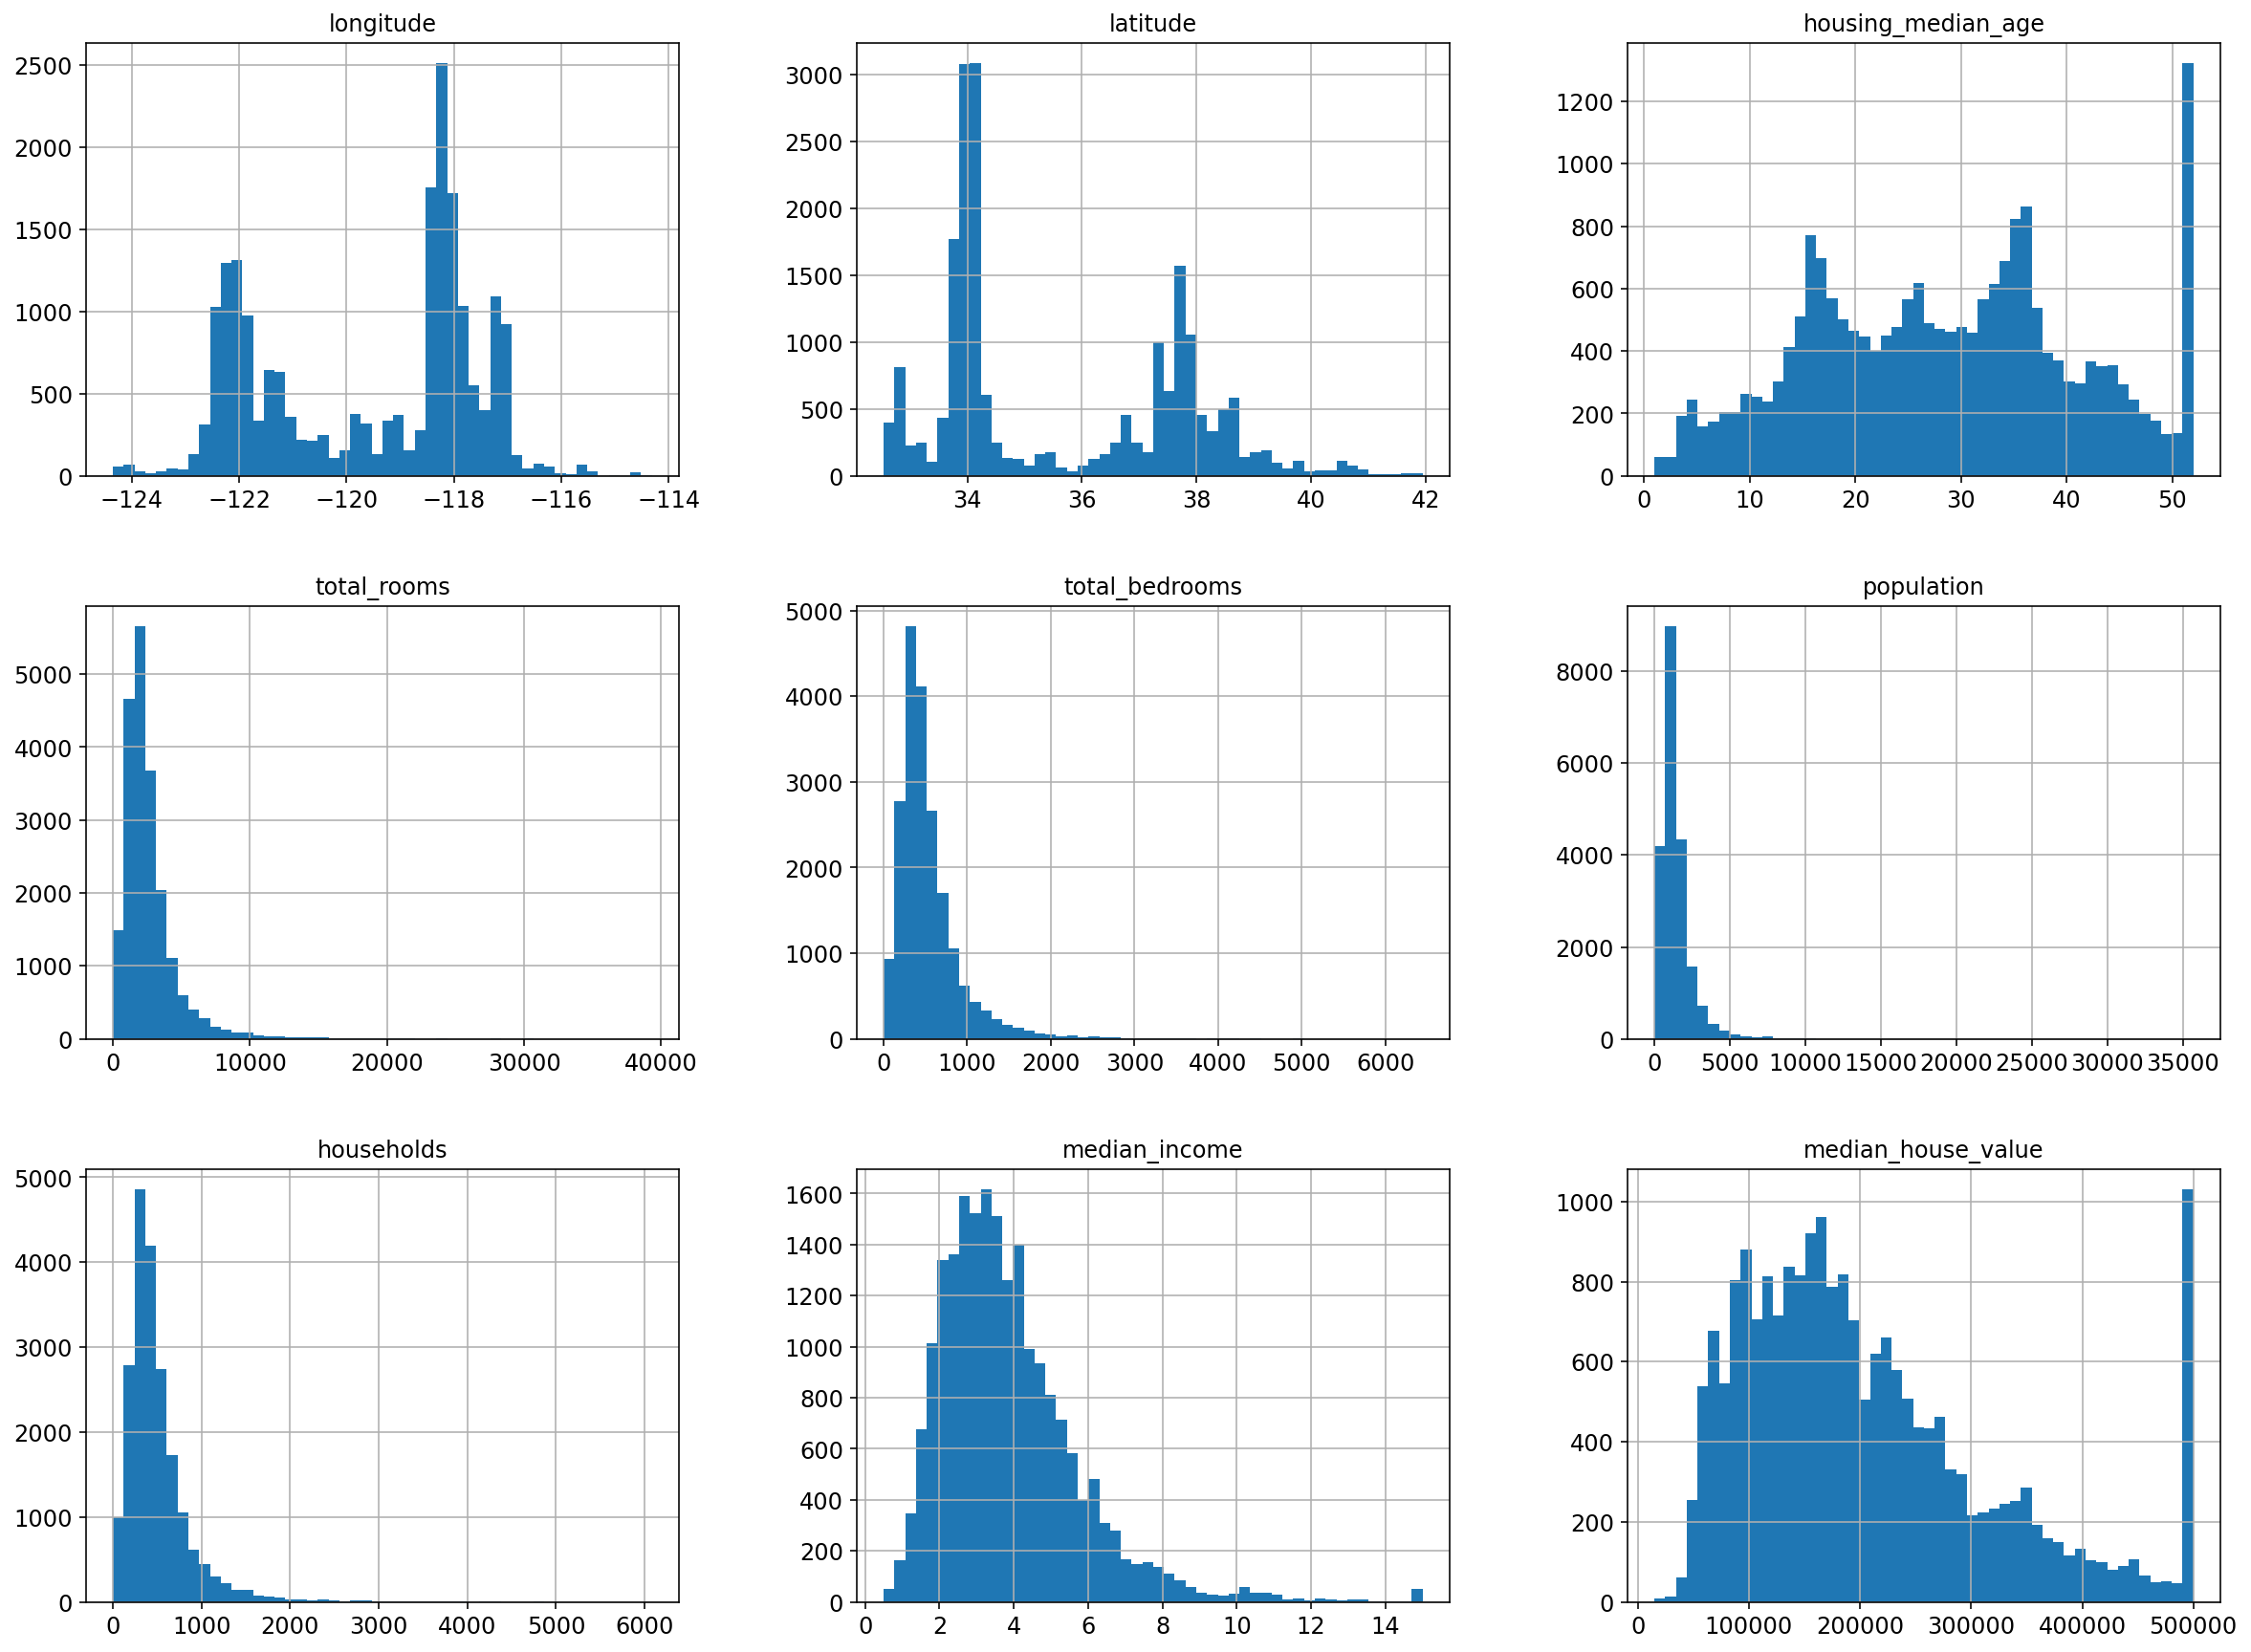

In [45]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

:::{exercise}
:label: regression-model-2

¿Qué conclusiones puedes sacar de estos datos? ¿Cómo podemos proceder?

:::

## Creando un conjunto de test

La siguiente función hace una partición entre conjunto de entrenamiento y test de forma similar a `train_test_split` de `sklearn.model_selection`.

In [46]:
from sklearn.model_selection import train_test_split

In [47]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [48]:
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set))
print(len(test_set))

16512
4128


:::{exercise}
:label: regression-model-3

¿Qué problemas puede tener una partición de este tipo? ¿Cómo podemos solventarlo? Véase [`StratifiedShuffleSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html)

:::

Debemos dejar el conjunto de test apartado antes de hacer cualquier transformación y una vez hayamos concluido la tarea de desarrollar modelos de predicción, podremos usarlo para evaluar dichos modelos. Antes de seguir, vamos a visualizar los datos de los que disponemos para obtener más información de cara a diseñar procesamiento y entrenamiento de modelos. 

In [49]:
housing = train_set.copy()

## Visualizando los datos

Realicemos un gráfico de tipo scatter para representar la información geográfica (longitud y latitud) del dataset.

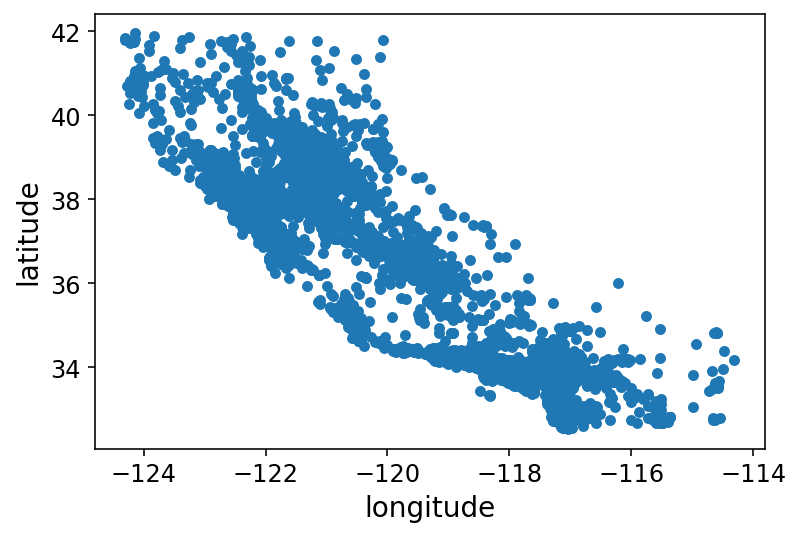

In [50]:
housing.plot(kind="scatter", x="longitude", y="latitude")
plt.show()

Vamos a incluir un poco de transparencia en los puntos para poder apreciar las zonas con mayor densidad 

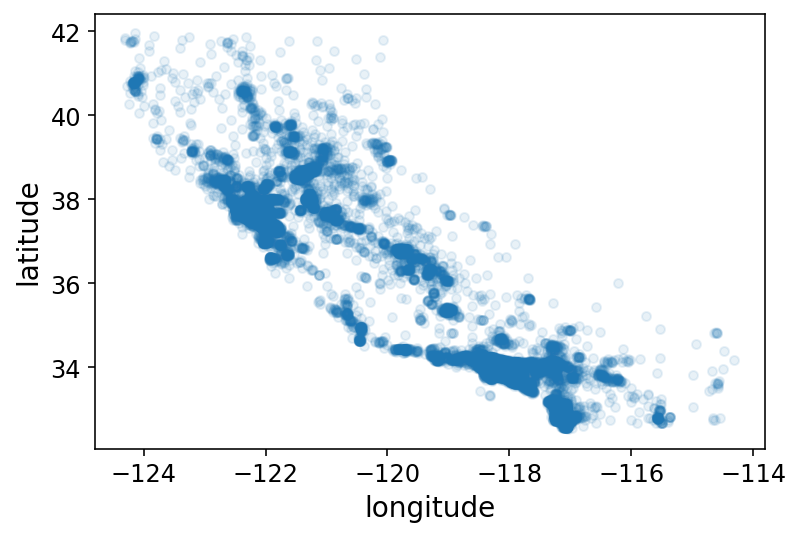

In [51]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
plt.show()

Ahora añadimos opciones para que el tamaño de cada punto venga en función de la población del distrito y añadimos una barra de color para el precio mediano (variable objetivo)

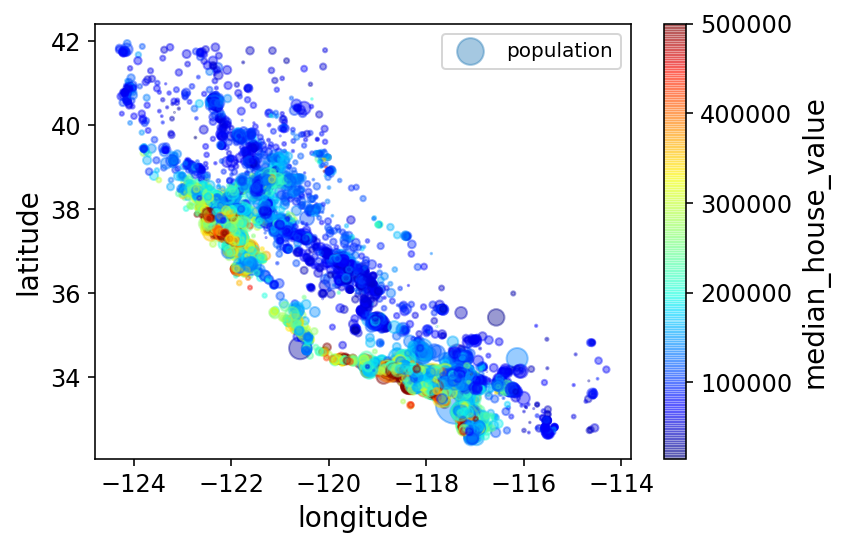

In [52]:
housing.plot(
    kind="scatter", 
    x="longitude", 
    y="latitude", 
    alpha=0.4,
    s=housing["population"]/100,
    label="population",
    c="median_house_value", 
    cmap=plt.get_cmap("jet"), 
    colorbar=True,
    sharex=False
)
plt.legend()
plt.show()

A continuación descargamos una imagen del mapa de california 

In [53]:
# Download the California image
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "end_to_end_project")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "california.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('./images/end_to_end_project/california.png',
 <http.client.HTTPMessage at 0x7f460a345b80>)

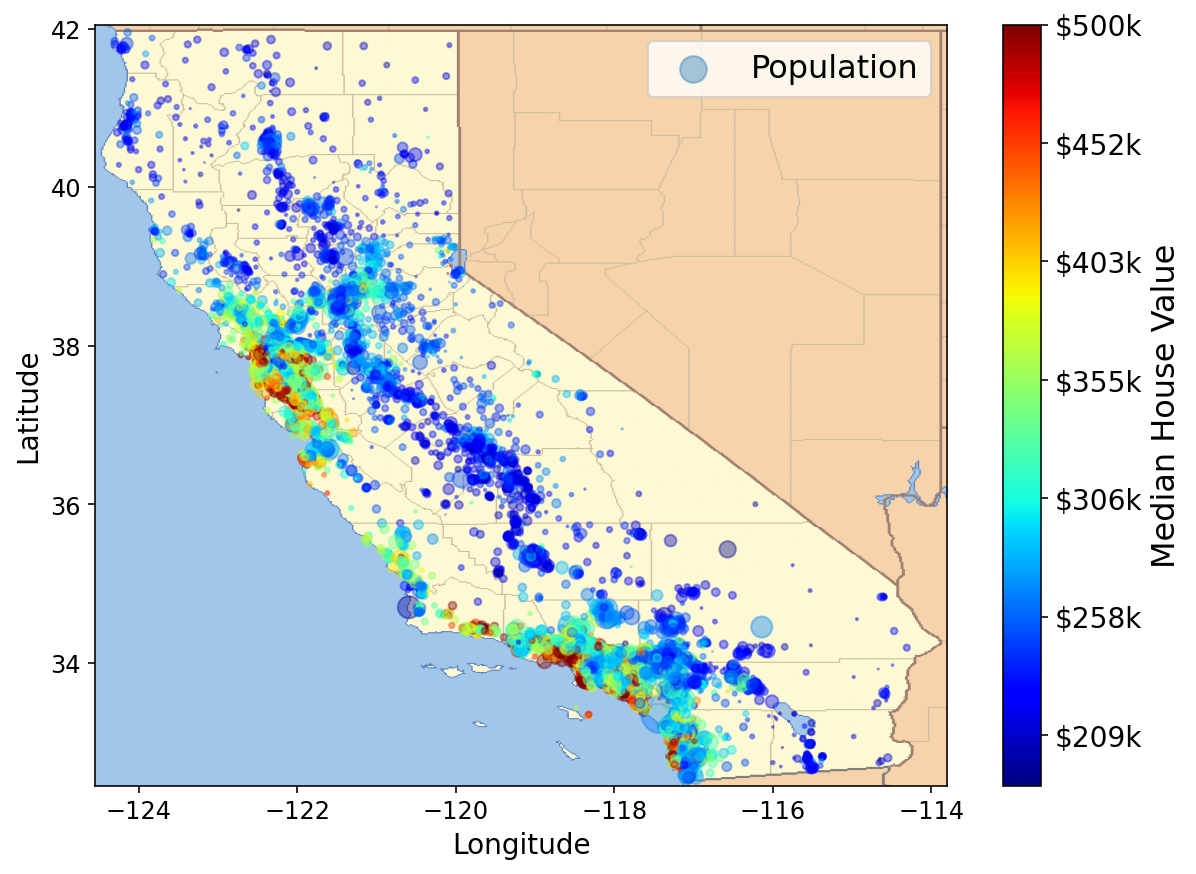

In [63]:
import matplotlib.image as mpimg

california_img=mpimg.imread(os.path.join(images_path, filename))
housing.plot(
    kind="scatter", 
    x="longitude", 
    y="latitude", 
    figsize=(10,7),
    s=housing['population']/100, 
    label="Population",       
    c="median_house_value", 
    cmap=plt.get_cmap("jet"),         
    colorbar=False, 
    alpha=0.4
)
plt.imshow(
    california_img, 
    extent=[-124.55, -113.80, 32.45, 42.05], 
    alpha=1,
    cmap=plt.get_cmap("jet")
)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(ticks=tick_values/prices.max())
cbar.ax.set_yticklabels([f"${round(v/1000)}k" for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
# save_fig("california_housing_prices_plot")
plt.show()